# Segmenting and Clustering Neighborhoods in Toronto

### Preliminary Step: import libraries from NYC lab

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

print('Libraries imported.')

Libraries imported.


### Step 1: Scraping and preparing Toronto neighborhood data frame

In [2]:
## Import BeautifulSoup package
!pip install beautifulsoup4
from bs4 import BeautifulSoup

In [3]:
## Import requests package to get HTML document behind URL
import requests

In [4]:
## Set URL of web page to scrape and create object
scrape_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wiki = requests.get(scrape_url)

In [5]:
## Create BeautifulSoup object based on extracted text document
nbhd_data = wiki.text
soup = BeautifulSoup(nbhd_data, 'html.parser')

In [6]:
#print(soup.prettify(formatter="html5"))

In [7]:
# Looking at above soup output, the easiest initial filter is to select text that falls under the sortable table of postal codes
Toronto_table = soup.find(class_="wikitable sortable")
#Toronto_table

In [8]:
# Extract all elements of postal code table
table_headers = Toronto_table.findAll("th")
table_headers

[<th>Postal Code
 </th>,
 <th>Borough
 </th>,
 <th>Neighbourhood
 </th>]

In [9]:
# define the dataframe columns and instantiate using pandas
column_names = []
for header in range(0,len(table_headers)):
    column_names.append(table_headers[header].get_text().replace('\n', '').replace(' ', ''))
Tor_nbhds = pd.DataFrame(columns=column_names)
Tor_nbhds

,PostalCode,Borough,Neighbourhood


In [10]:
table_cells = Toronto_table.findAll("td")
#table_cells

In [11]:
# Assign rows to pandas dataframe --> Info in sets of three
counter = 0
endpoint = int(len(table_cells)/3)
for row in range(0, endpoint):
    Tor_nbhds = Tor_nbhds.append({"PostalCode":table_cells[row + counter].get_text().replace('\n', ''),
                      "Borough":table_cells[row + counter + 1].get_text().replace('\n', ''),
                      "Neighbourhood":table_cells[row + counter + 2].get_text().replace('\n', '')}, ignore_index=True) 
    counter = counter + 2

In [12]:
# Remove rows with unassigned Borough since it is useless for ensuing analysis
Tor_nbhds = Tor_nbhds[Tor_nbhds.Borough != "Not assigned"].reset_index().drop(columns=['index'])

In [13]:
# Check to make sure that data frame has desired structure and information!
Tor_nbhds

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [14]:
# Find number of rows and columns in dataframe
Tor_nbhds.shape

(103, 3)

### Step 2: Add geospatial information to data frame

In [15]:
# Install and import geocoder
!pip install geocoder
import geocoder

#### The Google API isn't working, so change to ArcGIS. This means that (Lat, Long) pairs will differ somewhat from the provided CSV file.

In [16]:
# Modify provided code for assignment to iterate overall all postal codes
latitude = []
longitude = []

for row in range(len(Tor_nbhds)):
    # initialize your variable to None
    lat_lng_coords = None
    
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Toronto, Ontario'.format(Tor_nbhds.loc[row, "PostalCode"]))
      lat_lng_coords = g.latlng
    
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

In [17]:
# Add latitude and longitude columns to dataframe
Tor_nbhds["Latitude"] = latitude
Tor_nbhds["Longitude"] = longitude

In [18]:
Tor_nbhds

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831
6,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
7,M3B,North York,Don Mills,43.74923,-79.36186
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804


### Step 3: Repeat clustering process from NYC practice lab

#### Use geopy library to get the latitude and longitude values of Toronto

In [19]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with superimposed neighborhoods (i.e. postal codes)

In [20]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Tor_nbhds['Latitude'], Tor_nbhds['Longitude'], Tor_nbhds['Borough'], Tor_nbhds['PostalCode']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare credentials

In [21]:
CLIENT_ID = '4TV2RA3LUFSZQAE403CGRBOQTX4XFKEAA54ZEDIZGQIUDTJ3' # your Foursquare ID
CLIENT_SECRET = 'F3AOV2R4QNXBPTWEYNVDLSUXHLFCNMG4STR4QCDAY2BQDIAL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

#### Extract Top 100 venues for each neighborhood

In [24]:
### Copy function from NYC practice lab

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
toronto_venues = getNearbyVenues(Tor_nbhds.iloc[:,0], Tor_nbhds.iloc[:,3], Tor_nbhds.iloc[:,4]) 

M3A
M4A
M5A
M6A
M7A
M9A
M1B
M3B
M4B
M5B
M6B
M9B
M1C
M3C
M4C
M5C
M6C
M9C
M1E
M4E
M5E
M6E
M1G
M4G
M5G
M6G
M1H
M2H
M3H
M4H
M5H
M6H
M1J
M2J
M3J
M4J
M5J
M6J
M1K
M2K
M3K
M4K
M5K
M6K
M1L
M2L
M3L
M4L
M5L
M6L
M9L
M1M
M2M
M3M
M4M
M5M
M6M
M9M
M1N
M2N
M3N
M4N
M5N
M6N
M9N
M1P
M2P
M4P
M5P
M6P
M9P
M1R
M2R
M4R
M5R
M6R
M7R
M9R
M1S
M4S
M5S
M6S
M1T
M4T
M5T
M1V
M4V
M5V
M8V
M9V
M1W
M4W
M5W
M8W
M9W
M1X
M4X
M5X
M8X
M4Y
M7Y
M8Y
M8Z


In [26]:
# Total number of venues is 2,405
toronto_venues.shape

(2405, 7)

In [27]:
venue_count = toronto_venues.groupby('Neighborhood').count()[['Venue']].reset_index()
venue_count

,Neighborhood,Venue
0,M1B,3
1,M1C,2
2,M1E,3
3,M1G,4
4,M1H,1
5,M1J,5
6,M1K,3
7,M1L,10
8,M1M,8
9,M1N,4


#### Keep neighborhoods with at least 10 venues, otherwise difficult to use in cluster analysis

In [28]:
good_nbhd = venue_count[venue_count.Venue >= 10]

In [29]:
toronto_venues_keep = toronto_venues[toronto_venues.Neighborhood.isin(good_nbhd.Neighborhood)]

In [30]:
# Check to make sure above code worked
toronto_venues_keep.groupby('Neighborhood').count()[['Venue']].reset_index()

,Neighborhood,Venue
0,M1L,10
1,M1S,16
2,M1T,16
3,M1W,11
4,M2J,55
5,M2M,21
6,M2N,26
7,M3J,14
8,M3L,12
9,M3N,19


In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues_keep['Venue Category'].unique())))

There are 250 uniques categories.


#### Analyze each neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_keep[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_keep['Neighborhood']

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [33]:
# Move neighborhood column to the first column
nbhd_col = toronto_onehot.columns.get_loc("Neighborhood")
fixed_columns = [toronto_onehot.columns[nbhd_col]] + list(toronto_onehot.columns[np.r_[0:nbhd_col , (nbhd_col + 1):250]])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
5,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
# Total number of venues has been reduced to 2,181
toronto_onehot.shape

(2181, 250)

#### Group rows by neighborhood and find Top 5 categories for each one

In [35]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [36]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1L----
           venue  freq
0       Bus Line   0.2
1   Intersection   0.2
2         Bakery   0.2
3    Bus Station   0.1
4  Metro Station   0.1


----M1S----
                  venue  freq
0    Chinese Restaurant  0.12
1  Hong Kong Restaurant  0.06
2       Badminton Court  0.06
3        Discount Store  0.06
4             Newsagent  0.06


----M1T----
                  venue  freq
0           Pizza Place  0.12
1  Fast Food Restaurant  0.12
2         Deli / Bodega  0.06
3         Grocery Store  0.06
4  Cantonese Restaurant  0.06


----M1W----
                  venue  freq
0  Fast Food Restaurant  0.18
1           Pizza Place  0.09
2  Other Great Outdoors  0.09
3    Chinese Restaurant  0.09
4        Sandwich Place  0.09


----M2J----
                  venue  freq
0        Clothing Store  0.11
1  Fast Food Restaurant  0.05
2         Women's Store  0.05
3           Coffee Shop  0.05
4   Japanese Restaurant  0.04


----M2M----
                       venue  freq
0  Middle Eastern Restaur

#### Checked to make sure all frequencies are nonzero!

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Unlike NYC practice lab, we will only consider top 5 venues rather than top 10

In [38]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1L,Bakery,Intersection,Bus Line,Bus Station,Coffee Shop
1,M1S,Chinese Restaurant,Hong Kong Restaurant,Newsagent,Skating Rink,Shopping Mall
2,M1T,Pizza Place,Fast Food Restaurant,Bank,Grocery Store,Golf Course
3,M1W,Fast Food Restaurant,Other Great Outdoors,Pharmacy,Sandwich Place,Chinese Restaurant
4,M2J,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Juice Bar


#### Cluster Analysis

In [39]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [40]:
# determine optimal number of clusters using 'elbow' method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

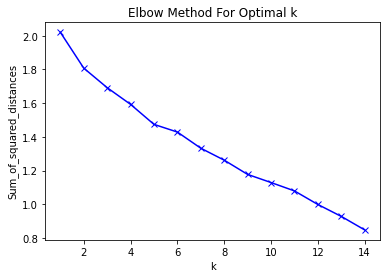

In [41]:
# Plot results to determine elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### There is not really an 'elbow' which seems to suggest that this data isn't of sufficient quality to determine clusters. However, there is a slight local flattening at k = 5, so this is what we will select to avoid going higher with only 48 samples.

In [54]:
## set optimal number of clusters

kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 1, 2, 2, 1, 0, 1, 1, 1, 2], dtype=int32)

In [55]:
### Reduce original data set to include only the 48 "kept" neighborhoods
Tor_nbhds_keep = Tor_nbhds[Tor_nbhds.PostalCode.isin(good_nbhd.Neighborhood)].reset_index().drop(columns=['index'])
Tor_nbhds_keep

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
3,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
5,M6B,North York,Glencairn,43.70687,-79.44812
6,M4C,East York,Woodbine Heights,43.68970,-79.30682
7,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
8,M5E,Downtown Toronto,Berczy Park,43.64536,-79.37306
9,M4G,East York,Leaside,43.70902,-79.36349


In [57]:
# drop cluster label column in case of re-running with new k value
neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace=True)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Tor_nbhds_keep

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,3,Coffee Shop,Breakfast Spot,Yoga Studio,Pub,Distribution Center
1,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,1,Clothing Store,Furniture / Home Store,Men's Store,Women's Store,Coffee Shop
2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,3,Coffee Shop,Sandwich Place,Portuguese Restaurant,Fried Chicken Joint,Bank
3,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192,2,Pizza Place,Athletics & Sports,Café,Breakfast Spot,Rock Climbing Spot
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop


In [58]:
### Check to ensure correct joining!
toronto_merged.shape

(48, 11)

In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine clusters

In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Downtown Toronto,0,Café,Grocery Store,Athletics & Sports,Italian Restaurant,Playground
25,North York,0,Korean Restaurant,Middle Eastern Restaurant,Pizza Place,Café,Supermarket


In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,North York,1,Clothing Store,Furniture / Home Store,Men's Store,Women's Store,Coffee Shop
4,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop
6,East York,1,Bus Line,Pharmacy,Grocery Store,Optical Shop,Pub
7,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Hotel,Café,Restaurant
8,Downtown Toronto,1,Coffee Shop,Cheese Shop,Restaurant,Breakfast Spot,Beer Bar
9,East York,1,Coffee Shop,Sporting Goods Shop,Bank,Burger Joint,Shopping Mall
10,Downtown Toronto,1,Coffee Shop,Clothing Store,Sandwich Place,Middle Eastern Restaurant,Bubble Tea Shop
12,East York,1,Yoga Studio,Indian Restaurant,Bridge,Middle Eastern Restaurant,Sandwich Place
13,Downtown Toronto,1,Coffee Shop,Hotel,Café,Restaurant,Gym
14,West Toronto,1,Park,Grocery Store,Bakery,Pharmacy,Middle Eastern Restaurant


In [62]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,East York,2,Pizza Place,Athletics & Sports,Café,Breakfast Spot,Rock Climbing Spot
5,North York,2,Pizza Place,Grocery Store,Pub,Fast Food Restaurant,Latin American Restaurant
29,North York,2,Pizza Place,Grocery Store,Shopping Mall,Discount Store,Pharmacy
37,Scarborough,2,Pizza Place,Fast Food Restaurant,Bank,Grocery Store,Golf Course
40,Etobicoke,2,Grocery Store,Park,Coffee Shop,Sandwich Place,Liquor Store
41,Scarborough,2,Fast Food Restaurant,Other Great Outdoors,Pharmacy,Sandwich Place,Chinese Restaurant


In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Downtown Toronto,3,Coffee Shop,Breakfast Spot,Yoga Studio,Pub,Distribution Center
2,Downtown Toronto,3,Coffee Shop,Sandwich Place,Portuguese Restaurant,Fried Chicken Joint,Bank


In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,Scarborough,4,Bakery,Intersection,Bus Line,Bus Station,Coffee Shop


### Observations:
 - Cluster 2 is by far the largest, with most members having "coffee shop" or "cafe" in the top 2 venue types
 - Cluster 3, which is the second largest, has members with mostly "pizza place" or "grocery store" in the top 2 venue types
 - Cluster 5, which has only one member, is unique due to the prevalence of transportation infrastructure
 - The remaining two clusters, with two members each, fall into the "coffee shop" or "cafe" dominance seen in Cluster 2, but possess other distinct venue types, such as Korean (Cluster 1) or Portuguese (Cluster 4) restaurants
 - Future analysis should look at merging similar venue types (e.g. coffee-based locations, regional cuisine) for better clustering results